Jonah M. Miller, Scientist, CCS-2, Los Alamos  National Lab

# Introduction

In this brief tutorial,  I will describe the simplest way of modeling a deadly infectious disease, such as COVID-19.  I will show that at early times, t he disease grows exponentially, but at late times, falls off like a Bell curve. I will solve the equations numerically with Python

A common mathematical model is the so-called [compartmental model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology), where diseases can move people between "categories" such as healthy, infectious, or truly sick. This is a large, well established field and there are many good resources on this topic. I started with the SIAM review article [The mathematics of infectious diseases](https://epubs.siam.org/doi/10.1137/S0036144500371907) (Hethcote, 2000). However, there are many excellent textbooks and more  modern reviews as well.



In [43]:
# Import python modules we need
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as  mpl
from matplotlib import pyplot as plt
mpl.rc('font',size=16)

# The SIR Model

We will use the SIR model, where the categories are:
- **S**usceptible
- **I**nfectious
- **R**ecovered

This model was first proposed by Kermack and McKendrick in their [seminal work](https://royalsocietypublishing.org/doi/10.1098/rspa.1927.0118), now known as Kermack-McKendrick theory.

We use a system of differential equations to model the number of people in each category. First some definitions.  We use the variables $S$, $I$, and $R$ to represent the number of people in each category. The total number of people is $N$. Therefore, the sum of people over all three categories must equal the total population:
$$S + I + R = N$$
In general, $S$, $I$, $R$, and $N$ can all be functions of time and space. An important assumption of this model is that **people who recover from the disease are immune and can't carry it or be re-infected.** This appears to be true for COVID-19 but it is not always true.

For simplicity, we assume that they are a function only of time, which we will call $t$. This allows us to treat the problem with ordinary, rather than partial, differential equations. Further, we will begin our analysis by assuming there are no births or deaths and $N$ is a constant. By the end of the tutorial, however, we will move beyond this simplistic assumption.

## No Deaths

Assuming no births or deaths, our equations are:
\begin{align}
\frac{dS}{dt} &= - \beta \frac{S I}{N}\\
\frac{dI}{dt} &= \beta \frac{S I}{N} - \gamma I\\
\frac{dR}{dt} &= \gamma I
\end{align}

The symbols here are:
- $\beta$ is the infection rate. An infected individual infects $\beta N$ other individuals per unit time.
- $\gamma$ is the average recovery rate such that $1/\gamma$ is the average time it takes  for an individual to recover  from the disease

A common metric of a disease the *power of infection*, which is the ratio of $\beta$ and $\gamma$:
$$R_0 = \frac{\beta}{\gamma}$$

These equations are often simplified by working with the *fractions* of the population that are  infected, susceptible, etc. These are denoted with lower-case variables
\begin{align}
s &= S/N\\
i &= I/N\\
r &= R/N
\end{align}

so that the SIR equations become

\begin{align}
\frac{ds}{dt} &= - \beta s i\\
\frac{di}{dt} &= \beta s i - \gamma i\\
\frac{dr}{dt} &= \gamma i
\end{align}

### The values  of the parameters

Let's try this out and see if we can model COVID-19. We will work in units of days. So, days to recovery, for example, is $1/\gamma$. The official time to self-quarantine for COVID-19 is 14 days, so I will set 
$$\gamma = 1/14.$$
We will set $\beta$ as
$$\beta  = \gamma R_0$$
The infectious power of the disease is between 2 and 5. It depends on countermeasures implemented. i.e., $R_0 = 5$ if nothing is done, and it can be as low as 2 if people are careful. Let's encode that in Python:

In [76]:
def get_beta_gamma(R=5,recovery_time=14):
    """Returns beta and gamma based 
    on recovery time and infectious power R
    """
    gamma = 1./recovery_time
    beta = R*gamma
    return beta,gamma

beta,gamma = get_beta_gamma()
print("beta = {}\ngamma = {}".format(beta,gamma))

beta = 0.3571428571428571
gamma = 0.07142857142857142


Our differential conditions need initial data. At the beginning, there has to be at least one infected person, since the disease has to start somewhere. In the early stages of the infection in the United States, there were 10s of cases, out of 327 million. That's something like 
$$i(t=0) = 10^{-8}.$$ 
We'll assume 
$$r(t=0) = 0$$ 
to start, and that
$$s(t=0) = 1 - i(t=0).$$
Let's encode that in Python:

In [77]:
i0 = 1e-8
r0 = 0
s0 = 1 - i0

Let's try solving this. We will use scipy's ODE integrator to solve the equations. It solves vector equations of the form
$$\frac{dU}{dt} = f(t,U)$$
in our case
$$U = \left(s, i, r\right)$$
and
$$f(t,U) = \left(-\beta s i, \beta s i-\gamma s i, \gamma i\right)$$
We'll encode the solution as a two-dimensional numpy array, where the row is time, and each column is $U$.

In [78]:
num_times = 180 # simulate for half a year
times = np.arange(num_times)
Us = np.empty((num_times,3))
Us[0] = np.array([s0,i0,r0])

We'll encode the right-hand-side $f$ as a Python function

In [79]:
def rhs(t, U, beta, gamma):
    s,i,r = U[0],U[1],U[2]
    return np.array([-beta*s*i,beta*s*i-gamma*i,gamma*i])

Let's load up the integrator code and set the initial conditions and parameters $\beta$ and $\gamma$

In [89]:
# import the tool
from scipy.integrate  import ode
# create the integrator
integrator = ode(rhs)
# set initial conditions and parameters
beta,gamma = get_beta_gamma(R=5,recovery_time=14)
integrator.set_initial_value(Us[0],0)
integrator.set_f_params(beta,gamma)

And let's integrate!

In [90]:
for i in range(len(times)-1):
    t = times[i+1]
    integrator.integrate(t)
    Us[i+1] = integrator.y

Let's see what it looks like. We can get s, i, and r as the columns of matrix:

In [91]:
s,i,r = Us[:,0],Us[:,1],Us[:,2]

And let's plot:

Text(0, 0.5, 'fraction of total population')

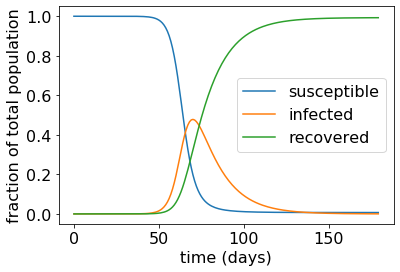

In [92]:
plt.plot(times,s,label='susceptible')
plt.plot(times,i,label='infected')
plt.plot(times,r,label='recovered')
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('fraction of total population')

You can see the "bell curve" people talk about in the news, which we want to flatten by reducing the infectious power of the disease. Making $R_0$ smaller will accomplish that. (Try it yourself! Change $R_0$ above. Try setting it to 3 or 4. You may also need to play with the duration of the simulation.) Something terrifying you should note. **In the worst case scenario, everyone gets the disease and half the population gets it at once.** That would completely overwhelm a country's medical system. Which we currently see happening in real time in Italy.

It's informative to look at this plot with the y-axis on a log scale:

Text(0, 0.5, 'fraction of total population')

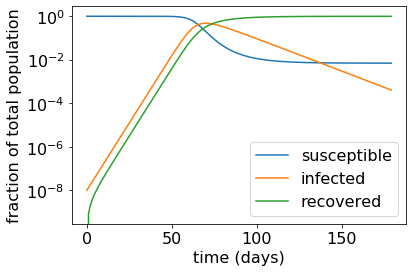

In [93]:
plt.semilogy(times,s,label='susceptible')
plt.plot(times,i,label='infected')
plt.plot(times,r,label='recovered')
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('fraction of total population')

While the population is susceptible to the disease, the number of infected cases grows exponentially. After a critical number of people are infected and begin to recover, the number of cases *decays* exponentially. This exponential growth is the reason why things can get out of hand so quickly. Monday is normal. On Friday, everyone is buying all the toilet paper. Changing the infectious power of the disease changes the rate of exponential growth, which is something we want.

## Including Deaths: The SIRD Model

Up until now, we have assumed that the disease is non-fatal. What about a fatal disease? We include this by adding a new category, $D$ for deceased, with 
$$d = D/N$$
Now $N$ is the the population at the beginning of the outbreak. We also add a new rate,
$$\sigma,$$
which is the case-fatality rate---the number of infected people who die per unit time. Our fraction equations now become:
\begin{align}
\frac{ds}{dt} &= - \beta s i\\
\frac{di}{dt} &= \beta s i - (\gamma + \sigma) i \\
\frac{dr}{dt} &= \gamma i\\
\frac{dd}{dt} &= \sigma i
\end{align}
We can relate $\sigma$ to $\gamma$ as
$$\sigma = R_1 \gamma,$$
where $R_1$ is the fraction of people who have the disease who die. For COVID-19, that's bout 3%. Or:
$$\sigma \approx 3\gamma/100$$
Let's code  it up.

In [132]:
R1 = 3./100.

To start, nobody has died yet.

In [116]:
d0 = 0

New initial conditions:

In [117]:
num_times = 180 # simulate for half a year
times = np.arange(num_times)
Us = np.empty((num_times,4))
Us[0] = np.array([s0,i0,r0,d0])

New right-hand-side:

In [118]:
def rhs(t, U, beta, gamma, sigma):
    s,i,r,d = U[0],U[1],U[2],U[3]
    return np.array([-beta*s*i,
                     beta*s*i-(gamma+sigma)*i,
                     gamma*i,
                     sigma*i
                    ])

Set up the integrator

In [133]:
integrator = ode(rhs)
# set initial conditions and parameters
beta,gamma = get_beta_gamma(R=3.4,recovery_time=14)
sigma = R1*gamma
integrator.set_initial_value(Us[0],0)
integrator.set_f_params(beta,gamma,sigma)

Integrate

In [134]:
for i in range(len(times)-1):
    t = times[i+1]
    integrator.integrate(t)
    Us[i+1] = integrator.y

And plot:

In [135]:
s,i,r,d = Us[:,0],Us[:,1],Us[:,2],Us[:,3]

Text(0, 0.5, 'fraction of total population')

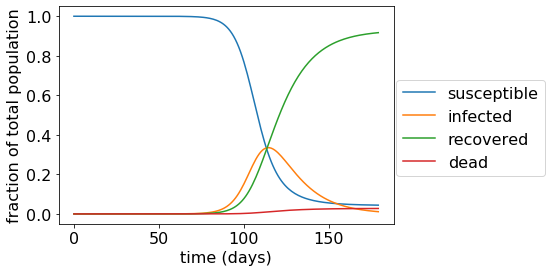

In [136]:
plt.plot(times,s,label='susceptible')
plt.plot(times,i,label='infected')
plt.plot(times,r,label='recovered')
plt.plot(times,d,label='dead')
plt.legend(bbox_to_anchor=[0.985,0.7])
plt.xlabel('time (days)')
plt.ylabel('fraction of total population')

Text(0, 0.5, 'fraction of total population')

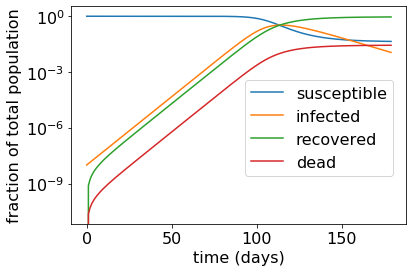

In [137]:
plt.semilogy(times,s,label='susceptible')
plt.plot(times,i,label='infected')
plt.plot(times,r,label='recovered')
plt.plot(times,d,label='dead')
plt.legend(bbox_to_anchor=[0.985,0.7])
plt.xlabel('time (days)')
plt.ylabel('fraction of total population')

The story roughly the same. But now that red line reflects people who never recover.

# Limitations

There are of course significant limitations to this toy model. We neglect:
- Births
- How the disease spreads or does not spread throughout space. Social distancing will help!
- How the global health care systems can react or fail to react as cases grow
- How different people and different age groups are more or less susceptible to the disease

So take all this analysis with a grain of salt. But it helped me understand at least a little bit of what's going on and build a better intuition for what's happening right now.

# Further reading

Here are some resources you may find helpful as you look at epidemiology and disease modeling:

- [Triplebyte's Tutorial on disease modeling](https://triplebyte.com/blog/modeling-infectious-diseases)
- [Kai Sasaki's ML fit of COVID-19 cases to the analytic solution of the SIR model](https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html)
- [SciPy's SIR example](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)
- [The Mathematics of Infectious Diseases, Hethcote, 2000](https://epubs.siam.org/doi/10.1137/S0036144500371907)
- [A Contribution to the Mathemat of Epidemics, Kermack and McKendrick, 1927](https://royalsocietypublishing.org/doi/10.1098/rspa.1927.0118)
- [Compartmental Models in Epidemiology](https://link.springer.com/chapter/10.1007/978-3-540-78911-6_2)